# Part 2: Modeling

The large size of the data and its complexness has constricted the choose of model to the tree based class. LGBMRegressor showed much better quality as random forest one, XGBoost model was also rejected due to its too long training time. Model parameters tuning and feature selection was done manually. There was also an attempt to use RFECV wrapper, but it showed worse quality. 

According to the task only sales in the range between 0 and 20 are considered, all other values have to be clipped to this range. As it was mantioned all shop/item/month objects can be divided into three classes:
- Objects with shop/item sale history,
- Object with only item sale history,
- Objects without any sale history or "new releases".

Objects from the last group are described only by their textual description (= their categorical features representation). It’s easy to see, that the problem strongly reminds a multi-class text classification one. The idea was used for the ensembling of some classification m models and a top-level tree-based regression:

<img src="ensamble.png" width=500 align="left"/><br clear="all" />

For the two the groups LGBM Redressor  was used similar to one model case. The segmentation of objects into three groups brought has noticeable improvement in  quality of the entire model. The usage of such kind of ensambling would not be possible on the full data set smaller data sets has allowed a finer parameters tuning of model parameters and more accurate feature selection.

Some étapes (eg. feature selection and hyperparameters tuning) were omitted in this report for the sake of the document size.

<nav class="toc">
<h2>Content:</h2>
<h4> Part 1: EDA, feature selection and data aggregation</h4>
<ol>
(the 1st notebook)
</ol>
<h4> Part 2: Modeling</h4>
<ol>
<li><a href="#one">One model</a>
<li><a href="#ensembling"> Ensembling</a>
      <ol>
        <li><a href="#knnsgd"> Two first level models: kNN ans SGD classifiers</a>
        <li><a href="#new"> New releases</a>
        <li><a href="#fplt"> Putting all together</a>       
      </ol>
<li><a href="#submition">Submition</a>    
</ol>
</nav>

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import copy
import pickle
import seaborn as sns
from random import sample

from aml_2_lib import My_Methric, det_shap_sample, reduce_mem_usage

In [2]:
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection, feature_selection, metrics

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
import shap

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.sparse import csr_matrix, hstack

plt.style.use(['seaborn'])

/Users/olip.andrei/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
DATA_FOLDER = path.join('final project', 'data')
items = pd.read_csv(path.join(DATA_FOLDER, 'items.csv'))
shops = pd.read_csv(path.join(DATA_FOLDER, 'shops.csv'))
kaggle_test = pd.read_csv(path.join(DATA_FOLDER, 'test.csv'))

In [6]:
class Sampler:
    def __init__(self, data_for_training, target, mode='all', test = [33]): 
        self.mode = 'sales'
        if  mode == 'reg': self.in_use = list(data_for_training[data_for_training['sales_cumsum']>0].index)  
        elif mode == 'new': self.in_use = list(data_for_training[data_for_training['months_on_the_market']==1].index)
        elif mode == 'rest':  self.in_use = list(data_for_training[(data_for_training['months_on_the_market']>1)&
                                                                   (data_for_training['sales_cumsum']<=0)].index)    
        elif mode == 'all': self.in_use = list(data_for_training.index)
        
        f = lambda x: sorted(list(x))
        self.indices_test  = f(set(data_for_training.query('date_block_num in @test').index)&set(self.in_use))
        self.indices_train = f(set(data_for_training.query('date_block_num<@test[0]').index)&set(self.in_use))

        self.indices_kaggle = set(data_for_training.query('date_block_num==34').index)
        self.indices_kaggle = sorted(list(set(self.indices_kaggle)&set(self.in_use)))
        
        self.y_train = target.loc[self.indices_train, self.mode].values
        if test[-1] < 34: self.y_test  = target.loc[self.indices_test, self.mode].values
        else: self.y_test = []    
    def get_full_y(self, y, data_for_training, months=[33]):
        indices = data_for_training[data_for_training['date_block_num'].isin(months)].index
        mask = data_for_training.loc[indices, ['date_block_num', 'shop_id', 'item_id']] 
        mask.loc[:, 'sales'] = np.zeros(mask.shape[0])
        indices_in = data_for_training[(data_for_training['date_block_num'].isin(months))&
                                       (data_for_training.index.isin(self.in_use))].index  
        mask.loc[indices_in, 'sales'] = y
        return mask.loc[:, 'sales'].values
    
class PreprocessedData:
    def __init__(self, t0=1):
        with open('data_file_names.pkl', 'rb') as file:
            files_data = pickle.load(file)
        self.data = {}
        self.index_head = ['date_block_num', 'item_id']
        for b in files_data:
            self.data.update({b: reduce_mem_usage(pd.read_csv(files_data[b], index_col=0)).
                                                  query('date_block_num>@t0').reset_index(drop=True)})
        self.target = pd.read_csv('target_new.csv', index_col=0)
        self.kaggle_test = pd.read_csv(path.join(DATA_FOLDER, 'test.csv'))
        self.data_base = pd.concat([self.data['base'].loc[:, self.index_head+['shop_id', 'sales_cumsum', 'item_category_id']], 
                                    self.data['time'].loc[:, ['months_on_the_market']]], axis=1)
        self.cut_features = []
    def init_sampler(self, mode, test = [31, 32, 33]):
        self.sampler = Sampler(self.data_base, self.target, mode=mode, test=test)
    def make_data_for_training(self, to_concate_file_name):
        data_for_training =self.data['base'].loc[:, self.index_head]
        features = []
        with open(to_concate_file_name, 'rb') as file:
            to_concate = pickle.load(file)
        for b in  self.data:
            data_for_training = pd.concat([data_for_training, self.data[b].loc[:, to_concate[b]]], axis=1)
            features += to_concate[b]
        return data_for_training, features  
    def get_train_set(self, to_concate_file_name, t_test=[33], t0=6, shop_filter=False, date_block_num=False):
        t = t_test[0]
        data_for_training, features = self.make_data_for_training(to_concate_file_name)
        if date_block_num: features = features + ['date_block_num']
        f = lambda x: sorted(list(x))
        ii = f(set(self.sampler.in_use)&set(data_for_training.query('@t0<=date_block_num<@t').index))
        X_train = data_for_training.loc[ii, features]
        y_train = self.target.loc[ii, 'sales']
        ii = f(set(self.sampler.in_use)&set(data_for_training.query('date_block_num in @t_test').index))
        X_test = data_for_training.loc[ii, features]
        if t < 34: y_test = self.target.loc[ii, 'sales']
        else: y_test = []
        ii = f(set(self.sampler.in_use)&set(data_for_training.query('date_block_num==34').index)) 
        X_kaggle_test = data_for_training.loc[ii, features] 
        with open('cat_features_all.pkl', 'rb') as file:
            cat_features = pickle.load(file)
        self.cat_features = copy.deepcopy(cat_features)
        for c in cat_features:
            if not c in features: 
                self.cat_features.remove(c)
        return X_train, X_test, y_train, y_test, X_kaggle_test

class My_Methric:
    def __init__(self, y_train, y_test):
        self.f = np.vectorize(lambda x: np.clip(x, 0, 20))
        self.y_train = y_train
        self.y_test  = y_test
        self.current_best = {}
    def val(self, y):
        y_pred = self.f(y)
        y_true = self.y_test 
        print('R-squared: {:f}'.format(r2_score(y_true, y_pred)))
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print('RMSE: {}'.format(rmse)) 

<h1 id="one"> One model</h1>

In [7]:
pp_data = PreprocessedData()
pp_data.init_sampler('all')
my_methric = My_Methric(pp_data.sampler.y_train, pp_data.sampler.y_test)

X_train, X_test, y_train, y_test, X_kaggle_test  = pp_data.get_train_set('features_one_model.pkl',
                                                                         t_test=[31, 32, 33], t0=6) 

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [256]:
lgb_params = {'feature_fraction': 0.75,
               'metric': 'rmse',
               'objective': 'regression_l2',
               'nthread':1, 
               'min_data_in_leaf': 10, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.01, 
               'bagging_seed': 2**7, 
               'num_leaves': 2**9, 
               'lambda_l2': 3,
               'bagging_freq':1,
               'verbose':0}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

model_lgb = lgb.train(lgb_params, lgb_train, 1330, valid_sets = (lgb_train, lgb_eval),
                      early_stopping_rounds=30, verbose_eval=100,
                      categorical_feature=pp_data.cat_features)
pred_lgb = model_lgb.predict(X_test.values)

Training until validation scores don't improve for 30 rounds
[10]	training's rmse: 1.16563	valid_1's rmse: 1.04836
[20]	training's rmse: 1.10814	valid_1's rmse: 1.00462
[30]	training's rmse: 1.05765	valid_1's rmse: 0.966848
[40]	training's rmse: 1.01337	valid_1's rmse: 0.934379
[50]	training's rmse: 0.974382	valid_1's rmse: 0.906966
[60]	training's rmse: 0.940368	valid_1's rmse: 0.883434
[70]	training's rmse: 0.910911	valid_1's rmse: 0.86347
[80]	training's rmse: 0.885042	valid_1's rmse: 0.846484
[90]	training's rmse: 0.862398	valid_1's rmse: 0.832615
[100]	training's rmse: 0.842969	valid_1's rmse: 0.820895
[110]	training's rmse: 0.825581	valid_1's rmse: 0.810927
[120]	training's rmse: 0.810351	valid_1's rmse: 0.80253
[130]	training's rmse: 0.796913	valid_1's rmse: 0.795598
[140]	training's rmse: 0.785195	valid_1's rmse: 0.789654
[150]	training's rmse: 0.77471	valid_1's rmse: 0.784672
[160]	training's rmse: 0.765472	valid_1's rmse: 0.78066
[170]	training's rmse: 0.757294	valid_1's rmse

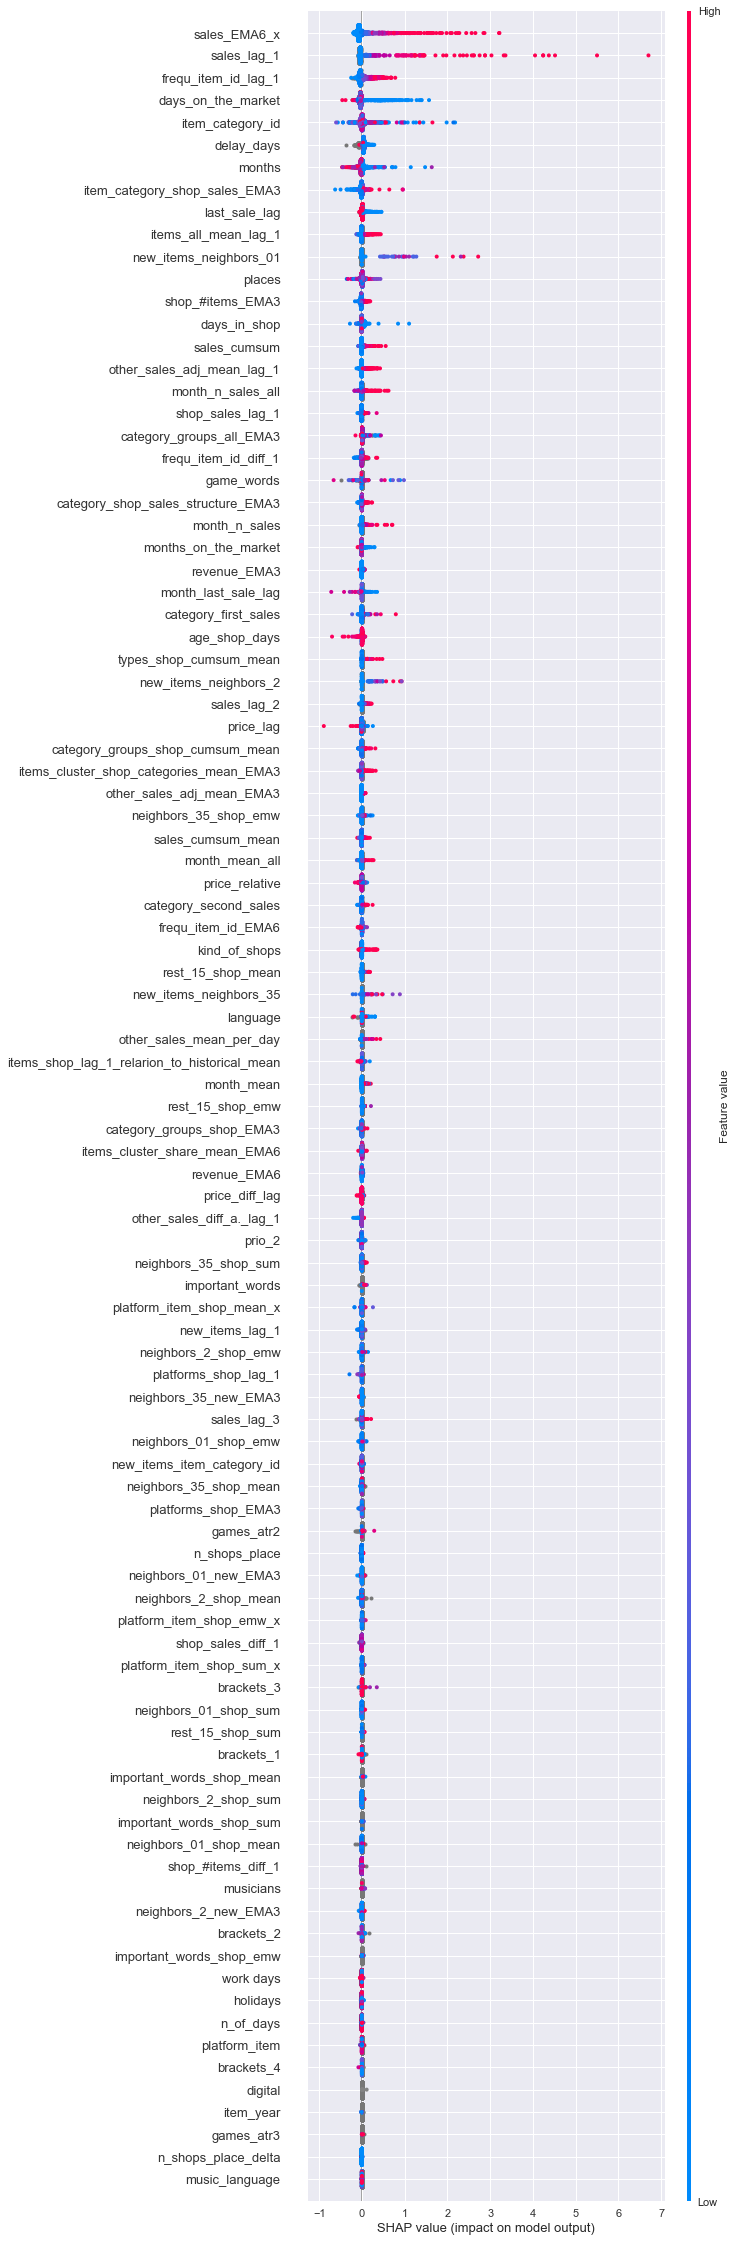

In [257]:
X = X_test.loc[det_shap_sample(1500, X_test.index, pp_data.target, type_='sales'), :]
explainer_raw = shap.TreeExplainer(model_lgb)  

shap_values = explainer_raw.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=X.columns, max_display = X.shape[1])

<h1 id="ensembling"> Ensembling</h1>

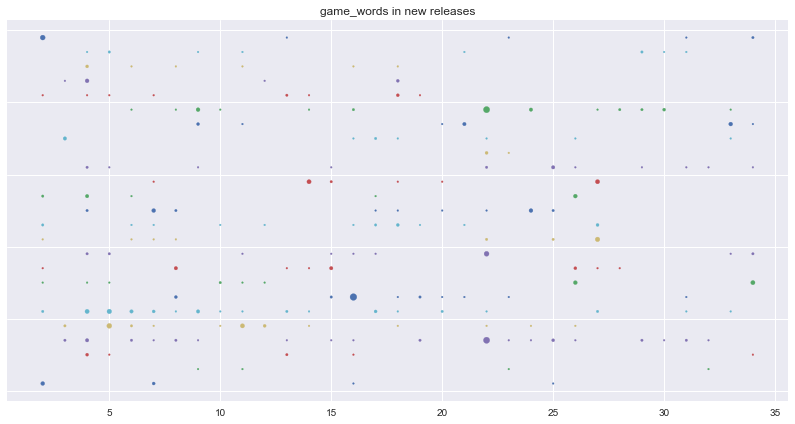

In [102]:
# check for relevance of cat. features for new new releases
c = 'game_words'
data = pd.concat([pp_data.data['base'].loc[:, ['item_id','date_block_num']], 
                 pp_data.data['time'].loc[:, 'months_on_the_market'], 
                 pp_data.data['item_name'].loc[:, c]] , axis=1).dropna().astype(int).query(
                 'months_on_the_market==1').groupby(['item_id', 'date_block_num'], as_index=False
                 )[c].first().pivot_table(index=c, columns='date_block_num', values='item_id', 
                                                  aggfunc='count')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
axes.set_title(c+ ' in new releases')
axes.set(yticklabels=[])

for i in range(25, 50):
    tmp = data.columns
    months = (i+0.5)*data.iloc[i, :].map(np.sign)
    axes.scatter(tmp, months, s=3*data.iloc[i, :], label='months')

<h3 id="knnsgd"> Two first level models: kNN ans SGD classifiers</h3>

In [16]:
class to_OneHot:
    def __init__(self, to_product, other_cat):
        self.oh = OneHotEncoder(handle_unknown='ignore')
        self.columns_to_product = to_product
        self.columns_to_add = other_cat
    def hashing(self, X):
        df = X.copy()
        columns = copy.deepcopy(list(self.columns_to_add))
        for c in self.columns_to_product:
            name = 'shop_' + c
            # hashing
            df[name] = 1000000*df['shop_id'] + df[c] + 10000*(np.sign(abs(df['months']-12))+1)
            columns.append(name)
        df['dig_12'] = (np.sign(abs(df['shop_id']-55))-1)*(df['digital']+ 999) + 10000*(np.sign(abs(df['months']-12))+1)
        columns.append('dig_12')
        return df.loc[:, columns]
    def fit(self, X):
        self.oh.fit(self.hashing(X))
    def transform(self, X):
        return self.oh.transform(self.hashing(X))
    
class add_columns:
    def __init__(self, to_product, other_cat):
        self.to_onehot = to_OneHot(to_product, other_cat)
        self.scaler = MinMaxScaler()
    def fit(self, X_train, cat_features, num_features):
        self.cat_features = cat_features
        self.num_features = num_features
        self.to_onehot.fit(X_train.loc[:, self.cat_features])
        self.scaler.fit(X_train.loc[:, self.num_features].replace({-999: 0})) 
    def transform(self, X):
        return csr_matrix(hstack([self.to_onehot.transform(X.loc[:, self.cat_features]), 
                                  self.scaler.transform(X.loc[:, self.num_features].replace({-999: 0}))]))

def knn(X_train_, X_test_, y_train, y_test, n_neighbors, bm, classify=True):
    oh = OneHotEncoder(handle_unknown='ignore')
    oh.fit(X_train_.fillna(-999))
    X_train = oh.transform(X_train_.fillna(-999)) 
    X_test = oh.transform(X_test_.fillna(-999))
    # regression as quality indicator
    if bm > 0:
        neigh = KNeighborsRegressor(algorithm='brute', n_neighbors=n_neighbors, metric='cosine', n_jobs=-1) 
        neigh.fit(X_train, y_train.astype(int).values)
        rmse = mean_squared_error(y_test, neigh.predict(X_test), squared=False)
        print('knn {}: {:.4f}, {:.4f}'.format(n_neighbors, rmse, rmse/bm))
    # classifier as feutures generator
    if classify:
        neigh = KNeighborsClassifier(algorithm='brute', n_neighbors=n_neighbors, metric='cosine', n_jobs=-1) 
        neigh.fit(X_train, y_train.astype(int).values)
        return neigh.predict_proba(X_test)
    else: return np.nan
def sgd_regression(X_train, X_test, y_train, y_test, bm, for_knn_sgd, regr=True):  
    ac = add_columns(for_knn_sgd['to_product'], for_knn_sgd['other_cat'])
    ac.fit(X_train.fillna(0), for_knn_sgd['cat_features'], for_knn_sgd['num_features'])
    X_train_line_model = ac.transform(X_train.fillna(0))
    X_test_line_model = ac.transform(X_test.fillna(0))
    if bm > 0 and regr:
        sgd = SGDRegressor(random_state=17)
        sgd.fit(X_train_line_model, y_train)
        y_pred = sgd.predict(X_test_line_model)
        s = mean_squared_error(y_test, y_pred, squared=False)
        print('sgd: {:.4f}, {:.4f}'.format(s, s/bm))
    return X_train_line_model, X_test_line_model    
def add_knn_sgd(X, knn_sgd, choose_, till_m=[33], train=True):
    columns = []
    for c in knn_sgd.columns:
        for b in choose_:
            if b in c:
                columns.append(c)
                break
    if train:            
        t = min(till_m)
        X = pd.concat([X.fillna(-999).reset_index(drop=True), 
                       knn_sgd.query('date_block_num<@t').loc[:, columns].reset_index(drop=True)], axis=1)
    else:
        X = pd.concat([X.fillna(-999).reset_index(drop=True), 
                   knn_sgd.query('date_block_num in @till_m').loc[:, columns].reset_index(drop=True)], axis=1)
    return X

In [104]:
pp_data.init_sampler('new')
results = pp_data.data_base.loc[pp_data.sampler.in_use, pp_data.index_head+['shop_id']].query('date_block_num>12')
for i, b in enumerate(['knn_200_', 'knn_250_', 'knn_350_', 'sgd_log_', 'sgd_modified_huber_']):
    tmp = pd.DataFrame([], columns=[b+str(k) for k in range(21)], index=results.index)
    results = pd.concat([results, tmp], axis=1)

In [105]:
with open('for_knn_sgd.pkl', 'rb') as file:
    for_sgd = pickle.load(file)

In [106]:
for m in range(13, 35):
    pp_data.init_sampler('new', test=[m])
    # knn
    X_train, X_test, y_train, y_test, _ = pp_data.get_train_set('knn_features.pkl', t_test=[m], t0=2)   
    ii = results[results.date_block_num==m].index
    if m < 34: bm = mean_squared_error(y_test, np.zeros(len(y_test)), squared=False)
    else: bm=0    
    print('{}, rmse by 0: {:.4f}'.format(m, bm))
    nn = [200, 250, 350]
    if True:
        for i, n_neighbors in enumerate(nn):  
            columns= results.iloc[:, 3+21*i:3+21*(i+1)].columns
            results.loc[ii, columns] = knn(X_train, X_test, y_train, y_test, n_neighbors, bm, classify=True)   
    #sgd
    if True:
        X_train, X_test, y_train, y_test, _ = pp_data.get_train_set('sgd_features.pkl', t_test=[m], t0=2)
        X_train_line_model, X_test_line_model = sgd_regression(X_train, X_test, y_train, y_test, bm, for_sgd, regr=True)  
        for i, l in enumerate(['log', 'modified_huber']):
            sgd = SGDClassifier(loss=l)
            sgd.fit(X_train_line_model, y_train)
            p = len(nn) + i  
            columns= results.iloc[:, 3+21*p:3+21*(p+1)].columns
            results.loc[ii, columns] = sgd.predict_proba(X_test_line_model)  
results.to_csv('knn_sgd.csv')

13, rmse by 0: 2.0889
knn 200: 1.7283, 0.8274
knn 250: 1.7361, 0.8311
knn 350: 1.7496, 0.8376
sgd: 1.7642, 0.8446
14, rmse by 0: 3.0757
knn 200: 2.4899, 0.8095
knn 250: 2.5058, 0.8147
knn 350: 2.5260, 0.8213
sgd: 2.4895, 0.8094
15, rmse by 0: 2.6242
knn 200: 2.1875, 0.8336
knn 250: 2.1920, 0.8353
knn 350: 2.2030, 0.8395
sgd: 2.1907, 0.8348
16, rmse by 0: 3.1718
knn 200: 2.3759, 0.7491
knn 250: 2.3926, 0.7543
knn 350: 2.4207, 0.7632
sgd: 2.3353, 0.7363
17, rmse by 0: 2.2017
knn 200: 1.9131, 0.8689
knn 250: 1.9081, 0.8667
knn 350: 1.9001, 0.8630
sgd: 1.8173, 0.8254
18, rmse by 0: 1.7860
knn 200: 1.4510, 0.8125
knn 250: 1.4533, 0.8137
knn 350: 1.4767, 0.8268
sgd: 1.5965, 0.8939
19, rmse by 0: 2.4647
knn 200: 1.9679, 0.7985
knn 250: 1.9618, 0.7960
knn 350: 1.9436, 0.7886
sgd: 1.8717, 0.7594
20, rmse by 0: 3.3138
knn 200: 2.7381, 0.8263
knn 250: 2.7123, 0.8185
knn 350: 2.6785, 0.8083
sgd: 2.5557, 0.7712
21, rmse by 0: 2.2932
knn 200: 1.9466, 0.8489
knn 250: 1.9464, 0.8488
knn 350: 1.9444, 0

<h3 id="new"> New releases</h3>

In [19]:
pp_data.init_sampler('new')
my_methric = My_Methric(pp_data.sampler.y_train, pp_data.sampler.y_test)

knn_sgd = pd.read_csv('knn_sgd.csv', index_col=0)

In [105]:
def cv_timeseries(t, params, choose_, sgd='sgd_mod_hub_', t0=13, model='lgbm', shop_filter=False):
    scores = []
    for k in [32, 33, 31]: 
        print(k)
        X_train, X_test, y_train, y_test, X_kaggle_test = pp_data.get_train_set('features_new_for_sgd.pkl',
                                                                       t_test=[k], t0=13, date_block_num=True) 
        
        X_train = add_knn_sgd(X_train, knn_sgd, choose_, till_m=[k])
        X_test = add_knn_sgd(X_test, knn_sgd, choose_, till_m=[k], train=False)
        if model == 'lgbm':
            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
            model_lgb_new = lgb.train(params, lgb_train, 1500, valid_sets = (lgb_train, lgb_eval),
                                  early_stopping_rounds=30, verbose_eval=10,
                                  categorical_feature=pp_data.cat_features
                                     )
            y_pred = model_lgb_new.predict(X_test.values)
        elif model=='rf':
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
        elif model=='xgb':      
            xgb_ = xgb.XGBRegressor(**params)  
            xgb_model = xgb_.fit(X_train.fillna(-999), y_train, 
                                 eval_set=[(X_train.fillna(-999), y_train), (X_test.fillna(-999), y_test)],  
                                 eval_metric='rmse',
                                 early_stopping_rounds=30, verbose=False)

            y_pred = xgb_model.predict(X_test.fillna(-999))
            model_lgb_new=None
            print('best_iteration: {}'.format(xgb_model.best_iteration))
        s = mean_squared_error(y_test, y_pred, squared=False)
        print(s)
        scores.append(s)
    print(np.mean(scores))
    return scores, model_lgb_new, X_test

In [ ]:
lgb_params = {'feature_fraction': 0.75,
       'metric': 'rmse',
       'objective': 'rmse', 
       'nthread':1, 
       'min_data_in_leaf': 10, 
       'bagging_fraction': 0.75, 
       'learning_rate': 0.01,  
       'bagging_seed': 2**7, 
       'num_leaves': 2**6, 
       'lambda_l1': 10,
       'bagging_freq': 1, 
       'verbose':0}

xgb_params = {'max_depth': 10, 
              'n_estimators': 1500,
              'min_child_weight': 1, 
              'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'eta': 0.01} 

scores, model, X_test = cv_timeseries(31, lgb_params, ['knn_200', 'knn_350','sgd'], model='lgbm')
#scores, model, X_test = cv_timeseries(31, xgb_params, ['knn_250','sgd'], model='xgb')
scores

In [ ]:
lgb: [2.021811639163288, 1.2800172767015539, 1.2484780730345828] 'knn_200', 'knn_350'
xgb: [2.0135530743552135, 1.3128400889567142, 1.2511903525790098] 'knn_250'

<h3 id="plt"> Putting all together</h3>

In [297]:
pp_data.init_sampler('all', test=[31, 32, 33])
my_methric = My_Methric(pp_data.sampler.y_train, pp_data.sampler.y_test)

In [83]:
filename = 'features_one_model.pkl'
with open(filename, 'rb') as file:
    tmp = pickle.load(file)

In [123]:
def putting_all_together(nn, new_booster='xgb', files = ['new', 'rest', 'reg'], t_test=[31, 32, 33], 
                         choose=['knn_200', 'knn_350', 'sgd'], submition=False):
    index_head = ['date_block_num', 'shop_id', 'item_id']
    y_pred_full = np.zeros(pp_data.data_base.query('date_block_num in @t_test').shape[0])
    for i, f in enumerate(files):
        print(f)
        with open('settings_'+f+'.pkl', 'rb') as file:
            settings = pickle.load(file)
        pp_data.init_sampler(f)
        if f == 'new':
            X_train, X_test, y_train, y_test, X_kaggle_test = pp_data.get_train_set(
                                settings['features_dict'], t_test=t_test, t0=settings['t0'], date_block_num=True) 
            X_test = add_knn_sgd(X_test, knn_sgd, choose, till_m=t_test, train=False)
            X_train = add_knn_sgd(X_train, knn_sgd, choose, till_m=t_test)
        else:
            X_train, X_test, y_train, y_test, X_kaggle_test = pp_data.get_train_set(
                                settings['features_dict'], t_test=t_test, t0=settings['t0']) 

        if  new_booster=='xgb':
            xgb_ = xgb.XGBRegressor(**settings['params'])  
            model = xgb_.fit(X_train, y_train, eval_metric='rmse', verbose=False)
        else:
            lgb_train = lgb.Dataset(X_train, y_train)
            if submition:
                model = lgb.train(settings['params'], lgb_train, nn[i], categorical_feature=pp_data.cat_features)
            else:
                lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
                model = lgb.train(settings['params'], lgb_train, nn[i], valid_sets = (lgb_train, lgb_eval), 
                                  categorical_feature=pp_data.cat_features, 
                                  early_stopping_rounds=30, verbose_eval=100)
                print('best iteration: {}'.format(model.best_iteration))
        y_pred = pp_data.sampler.get_full_y(model.predict(X_test), pp_data.data_base, months=t_test)
        pd.DataFrame(y_pred).to_csv(f+'_submition_prog.csv', index=False)
        y_pred_full += y_pred
    return y_pred_full

In [130]:
y_pred_full = putting_all_together([1500, 1500, 1500], new_booster='lgbm', t_test=[31, 32, 33])

new
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 1.78483	valid_1's rmse: 1.64599
[200]	training's rmse: 1.57829	valid_1's rmse: 1.56977
[300]	training's rmse: 1.47192	valid_1's rmse: 1.5594
Early stopping, best iteration is:
[283]	training's rmse: 1.48631	valid_1's rmse: 1.55794
best iteration: 283
rest
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.279567	valid_1's rmse: 0.281582
[200]	training's rmse: 0.248299	valid_1's rmse: 0.2648
[300]	training's rmse: 0.234151	valid_1's rmse: 0.258888
[400]	training's rmse: 0.225526	valid_1's rmse: 0.255571
[500]	training's rmse: 0.219597	valid_1's rmse: 0.253584
[600]	training's rmse: 0.215034	valid_1's rmse: 0.25256
[700]	training's rmse: 0.211369	valid_1's rmse: 0.252001
[800]	training's rmse: 0.208295	valid_1's rmse: 0.251663
[900]	training's rmse: 0.205507	valid_1's rmse: 0.251421
[1000]	training's rmse: 0.202964	valid_1's rmse: 0.25113
[1100]	training's rmse: 0.20

categorical_feature in Dataset is overridden.
New categorical_feature is ['brackets_3', 'game_words', 'item_category_id', 'kind_of_shops', 'language', 'months', 'places']


Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.982688	valid_1's rmse: 0.912336
[200]	training's rmse: 0.857666	valid_1's rmse: 0.845933
[300]	training's rmse: 0.810905	valid_1's rmse: 0.8309
[400]	training's rmse: 0.783381	valid_1's rmse: 0.825443
[500]	training's rmse: 0.763032	valid_1's rmse: 0.822729
[600]	training's rmse: 0.74788	valid_1's rmse: 0.821074
[700]	training's rmse: 0.735728	valid_1's rmse: 0.820119
[800]	training's rmse: 0.725312	valid_1's rmse: 0.819586
[900]	training's rmse: 0.716231	valid_1's rmse: 0.819005
[1000]	training's rmse: 0.708077	valid_1's rmse: 0.818711
[1100]	training's rmse: 0.700652	valid_1's rmse: 0.818316
Early stopping, best iteration is:
[1105]	training's rmse: 0.700272	valid_1's rmse: 0.818293
best iteration: 1105


In [131]:
pp_data.init_sampler('all', test=[31, 32, 33])
my_methric = My_Methric(pp_data.sampler.y_train, pp_data.sampler.y_test)
my_methric.val(y_pred_full)

R-squared: 0.547357
RMSE: 0.7398021833864662


## Sumbition

In [17]:
nn = [300, 1400, 1100]
y_pred_full = putting_all_together(nn, new_booster='lgbm', t_test=[34], submition=True)

data_for_training = pp_data.base.copy()
kaggle_test_results(y_pred_full)